# February 2022  AuxTel data reduction 

Goal: take auxTel images, run ISR, and pass through the AOS pipeline to recover Zernikes


Prerequisites:
    
    * access to NCSA lsst-devl nodes 
    * working installation of ts_wep packages, on the `tickets/DM-31655` branch  ( see the following notes https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS for additional info on how to install and build the AOS packages)
    
Setup (that was used to run the analysis on a notebook opened in a browser using an ssh connection to the NCSA machine). Here `scichris` is my username, and `/project/scichris/aos/setup_aos_current.sh` the setup script that loads the AOS packages. In particular, the `ts_wep` installation used was `/project/scichris/aos/ts_wep` . The `54467` can be any other port number, as long as it is consistent between `ssh` connection and the 
    
Run in the terminal on the local machine:

    ssh -L 54467:localhost:54467 scichris@lsst-devl02
    
Run in the NCSA terminal after DUO authentication (I aliased these in `~/.bash_profile`:

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib     # first two aliased with "lsst"
    
    source /project/scichris/aos/setup_aos_current.sh  # aliased as "aos"
    jupyter notebook --no-browser --port=54467         # aliased as "jup" 
   
This should open the browser at the NCSA `/jhome` directory.  I navigate to `/jhome/link_to_project_aos/AOS/` to open this notebook.



# Contents:<a id='toc'></a>

 * [Workflow with three images, updating the out-of-focus WCS from sources in the in-focus image](#WCS)
  * [Load the raws](#raws)
  * [Do the ISR](#isr)
  * [Get source catalog](#sources)
    * [Using original WCS-based sources as an input to astrometry task](#originalWcs)
    * [Using the source detection task catalog as input to astrometry ](#detection)
  * [Run Zernike estimation](#zernikes)
  
 * [Workflow with two defocal images using donut template fitting](#template)
  * [Load the raw defocal images, do the ISR](#loadDefocal)
  * [Run donut template fitting and Zernike estimation](#fitDonuts)
  
 * [Summary](#summary)
  
  

# Example workflow using updated WCS information <a id='wcs'></a>

## Load the raws and ensure that there are intra, extra, and in-focus images <a id='raws'></a>

In [69]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
from lsst.daf import butler as dafButler

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 15

zscale = ZScaleInterval()


def preview_auxtel_exposures(year='2021', monthDay='0908', expStart=487, expEnd=490,
                            datasetRefOrType='raw', collection='LATISS/raw/all'):

    butler = dafButler.Butler('/repo/main/')
    
    # figure out how many images to plot
    nexp = expEnd-expStart

    # calculate how many cols and rows we need 
    if nexp > 3:
        ncol = 3
        nrows = (nexp // ncol) + 1
    else:
        ncol=nexp
        nrows = 1
        
    zscale = ZScaleInterval()
    # do the plotting 
    fig,axs = plt.subplots(nrows,ncol,figsize=(ncol*4,nrows*4))
    ax = np.ravel(axs)
    i=0
    for exp in range(expStart,expEnd):
        exposure = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                         'exposure':int(f'{year}{monthDay}00{exp}')
                                            },
                          collections=[collection])
        data = exposure.image.array
        vmin, vmax = zscale.get_limits(data)
        ax[i].imshow(data,vmin=vmin,vmax=vmax,origin=
                  'lower')
        ax[i].set_title(f"{year}{monthDay}, exp {exp},\n focusz={np.round(exposure.getMetadata()['FOCUSZ'],3)}")
        i += 1
    fig.subplots_adjust(hspace=0.35)

    # if there are more axes than exposures,
    # turn off the extra axes 
    ncells = nrows*ncol
    if ncells > nexp:
        for axis in ax[nexp:]:
            axis.axis("off")

/lsstdata/offline/instrument/LATISS/storage/2021-09-08/AT_O_20210908_000487-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-09-08/AT_O_20210908_000488-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-09-08/AT_O_20210908_000489-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


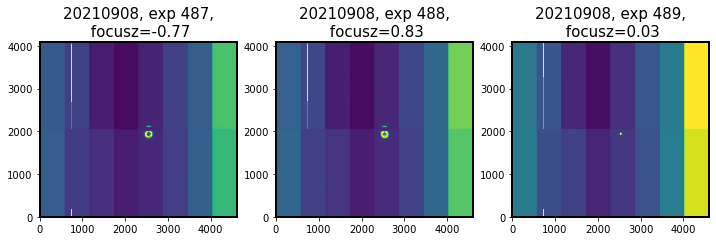

In [70]:
# analyze that for the test data 
preview_auxtel_exposures(monthDay='0908', expStart=487, expEnd=490)

## Run the ISR <a id='isr'></a>
[Go to table of contents](#toc)


First try with flats:


    ssh lsst-devl02

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib
    
    pipetask run  --data-query "exposure IN (2021090800487..2021090800489) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISRex --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types

The config file `testLatiss4.yaml` contains 

    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.Latiss
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: false
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doNanMasking: false
          doOverscan: true
          doVariance: false
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'

While running the pipetask (with `lsst_distrib` version `w_2022_05`) I get the following warning :

    ...
    numexpr.utils INFO: Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
    numexpr.utils INFO: NumExpr defaulting to 8 threads.
    lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 7 quanta for 1 tasks, graph ID: '1643835917.696073-3368255'
    conda.common.io INFO: overtaking stderr and stdout
    conda.common.io INFO: stderr and stdout yielding back
    py.warnings WARNING: /software/lsstsw/stack_20220125/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/obs_base/g20ff5da1ef+c94f9176fe/python/lsst/obs/base/formatters/fitsExposure.py:651: UserWarning: Reading file:///repo/main/u/czw/DM-32209/flatGen.20211013a-felh/20211013T214128Z/flat/r/FELH0600~empty/flat_LATISS_r_FELH0600~empty_RXX_S00_u_czw_DM-32209_flatGen_20211013a-felh_20211013T214128Z.fits with data ID {instrument: 'LATISS', detector: 0, physical_filter: 'FELH0600~empty', ...}: filter label mismatch (file is None, data ID is FilterLabel(band="r", physical="FELH0600~empty")).  This is probably a bug in the code that produced it.
      warnings.warn(
      ...

But it executes successfully. Show the postISR:


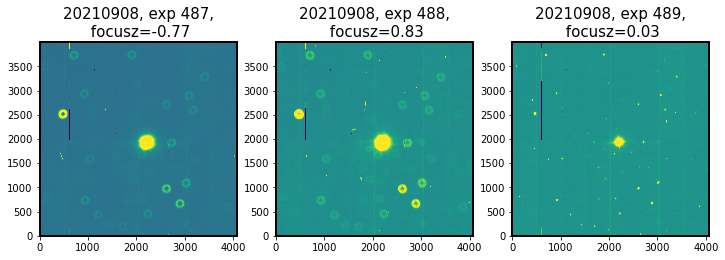

In [71]:
preview_auxtel_exposures(monthDay='0908', expStart=487, expEnd=490,
                         datasetRefOrType='postISRCCD', 
                         collection='u/scichris/Latiss/postISRex')

## 1) Get sources for AOS pipeline from the in-focus exposure <a id='sources'></a>
[Go to table of contents](#toc)

Now the problem is that the WCS attached to the exposure is 180 degree + several pixels off. Illustrate that by plotting the GAIA source catalog given the original WCS as well as rotated WCS:

In [2]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800489
                                        },
                      collections=['u/scichris/Latiss/postISRex'])

I load the sources from the reference catalog using the `ts_wep`  `GenerateDonutCatalogWcsTask` : 

In [3]:
from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface
from lsst.daf import butler as dafButler
from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (GenerateDonutCatalogWcsTask, 
                                                             GenerateDonutCatalogWcsTaskConfig)


# need to provide ra,dec, rotation angle of the exposure 
visitInfo = postIsr.getInfo().getVisitInfo()

boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()

# Load the ts_wep RefCatalogInterface
refCatInterface = RefCatalogInterface(boresightRa, boresightDec,boresightRotAng)

shardIds = refCatInterface.getShardIds()


butler = dafButler.Butler('/repo/main/', instrument='LATISS')
catalogName = 'gaia_dr2_20200414'
collections = 'refcats'

dataRefs, dataIds = refCatInterface.getDataRefs(shardIds, butler, catalogName, collections)


donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
donutCatConfig.filterName= 'phot_g_mean'

# instantiate the task with the appropriate config 
donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }

/project/scichris/aos/ts_wep/python/lsst/ts/wep/task/DonutSourceSelectorTask.py:84: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def selectSources(self, sourceCat, matches=None, exposure=None):


Illustrate the original WCS and the 180-deg off WCS to check whether the 180 degree offset has been resolved (the ticket is marked as  'Done' https://jira.lsstcorp.org/browse/DM-31997)

In [4]:
#Get the sources from reference catalog assuming the original WCS
originalWcs=postIsr.getWcs()
originalDonutCatStruct = donutCatTask.run(dataRefs, postIsr, )

In [44]:
originalWcs.isFlipped

True

In [5]:
# Obtain the sources from the reference catalog with the WCS rotated by 180 degrees 
import lsst.geom
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix

rotationInDeg = 180 

info = postIsr.getInfo().getVisitInfo()
orientation = (info.getBoresightRotAngle().asDegrees()+rotationInDeg)* lsst.geom.degrees
#  info.getBoresightRotAngle()# 0 * lsst.geom.degrees  # 
flipX = originalWcs.isFlipped
scale =  originalWcs.getPixelScale() # 0.2 * lsst.geom.arcseconds  # how many arcsec per pixel 
cdMatrix = makeCdMatrix(scale=scale, orientation=orientation, flipX=flipX)

pxOrigin = originalWcs.getPixelOrigin()

crpix = pxOrigin
crval = originalWcs.getSkyOrigin() # lsst.geom.SpherePoint(0.0*lsst.geom.degrees, 0.0*lsst.geom.degrees)
rotatedWcs = makeSkyWcs(crpix=crpix, crval=crval, cdMatrix=cdMatrix)

Compare the original and rotated WCS:

In [6]:
originalWcs

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [7]:
rotatedWcs

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [8]:
# obtain source catalog using the rotated WCs postIsr.setWcs(rotatedWcs)
postIsr.setWcs(rotatedWcs)
rotatedDonutCatStruct =  donutCatTask.run(dataRefs, postIsr, )

In [10]:
#Make magnitude cuts for cleaner illustration

import astropy.units as u
import numpy as np 

originalCatalog  = originalDonutCatStruct.donutCatalog
rotatedCatalog = rotatedDonutCatStruct.donutCatalog

mag_list = (originalCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

originalCatalog['mags'] = mag_array
mask = mag_array<16
originalCatalogMagCut = originalCatalog[mask]


mag_list = (rotatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

rotatedCatalog['mags'] = mag_array
mask = mag_array<16
rotatedCatalogMagCut = rotatedCatalog[mask]

Plot the postISR image with GAIA sources given the original WCS (yellow) and WCS rotated by 180 degrees (red):

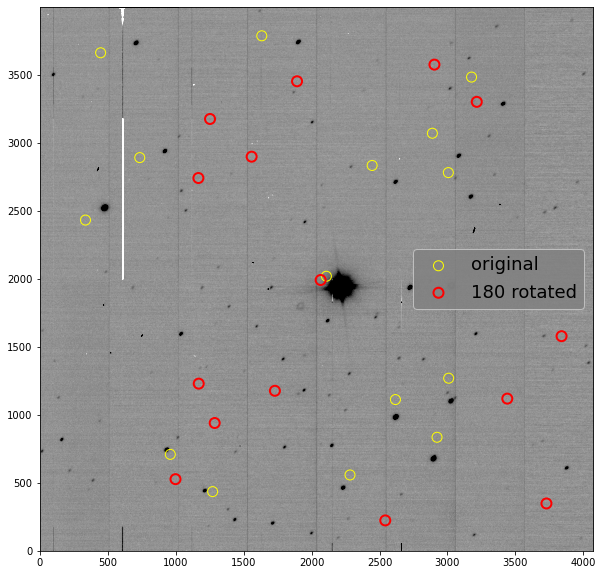

In [11]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
for cat,color,lw,label in zip([originalCatalogMagCut, rotatedCatalogMagCut], 
                    ['yellow', 'red'],
                       [1,2],
                       ['original', '180 rotated']):

    ax.scatter(cat['centroid_x'], 
           cat['centroid_y'], 
           s=100, 
           facecolors='none', edgecolors=color, lw=lw, 
           label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

Plot just the original sources:

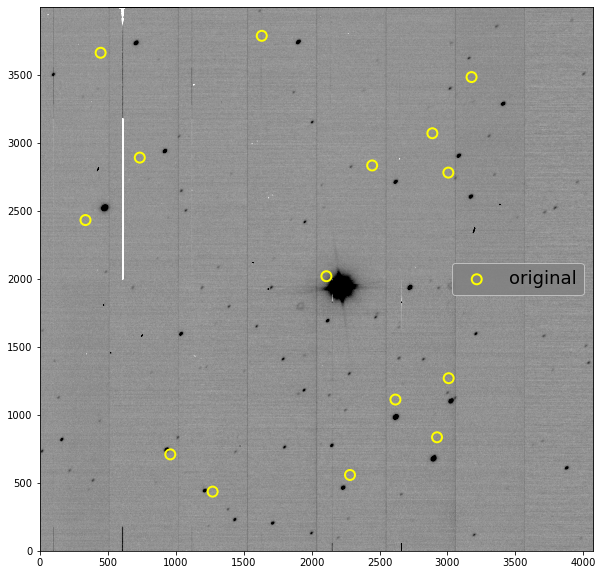

In [179]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
cat = originalCatalogMagCut
color = 'yellow'
lw = 2
label='original'

ax.scatter(cat['centroid_x'], 
       cat['centroid_y'], 
       s=100, 
       facecolors='none', edgecolors=color, lw=lw, 
       label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

Ok, looks like what used to be an issue is not anymore - perhaps auxTel data got re-ingested with WCS rotated by 180 deg.  Revert the  exposure WCS back to the original one:


In [12]:
postIsr.setWcs(originalWcs)

### 1a) Correct WCS using original WCS-based catalog as input for  astrometry fit <a id='originalWcs'></a>
[Go to table of contents](#toc)

Either way,  the original WCS is still ~20px off. 

Try using it as a first guess for the astrometry task":

In [190]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay

astromConfig = AstrometryTask.ConfigClass()
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.999
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 2
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15


Need to redefine filter label

In [25]:
# I'm forcing the exposure
# to have the same name as the one in the Gaia catalog for now

from lsst.afw.image import FilterLabel
postIsr.setFilterLabel(FilterLabel('phot_g_mean'))

In [158]:
    
# schema = lsst.afw.table.SourceTable.makeMinimalSchema()
# solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
# results = solver.run(sourceCat=originalDonutCatStruct, exposure=postIsr,)

But how to turn the `struct` to `sourceCatalog`?  Row by row populating the source catalog with sources....Based on https://github.com/lsst-ts/ts_phosim/blob/uw_dev/notebooks/analysis_notebooks/Create_wcs_from_phosim_out_of_focus_no_transpose.ipynb

In [182]:
sourceSchema = afwTable.SourceTable.makeMinimalSchema()
measBase.SingleFrameMeasurementTask(schema=sourceSchema)  # expand the schema
sourceCat = afwTable.SourceCatalog(sourceSchema)

sourceCentroidKey = afwTable.Point2DKey(sourceSchema["slot_Centroid"])
sourceIdKey = sourceSchema["id"].asKey()
sourceRAKey = sourceSchema["coord_ra"].asKey()
sourceDecKey = sourceSchema["coord_dec"].asKey()
sourceInstFluxKey = sourceSchema["slot_ApFlux_instFlux"].asKey()
sourceInstFluxErrKey = sourceSchema["slot_ApFlux_instFluxErr"].asKey()


catalog = originalCatalogMagCut

Nrows = len(catalog)
sourceCat.reserve(Nrows)

for i in range(Nrows):
    src = sourceCat.addNew()
    src.set(sourceIdKey, i)
    
    # set ra,dec 
    ra = lsst.geom.Angle(catalog['coord_ra'].iloc[i], lsst.geom.radians)
    src.set(sourceRAKey, ra)

    dec = lsst.geom.Angle(catalog['coord_dec'].iloc[i], lsst.geom.radians)
    src.set(sourceDecKey, dec)

    # set the x,y centroid
    x = catalog['centroid_x'].iloc[i]
    y = catalog['centroid_y'].iloc[i]
    point = lsst.geom.Point2D(x,y)
    src.set(sourceCentroidKey, point)

    # set the flux and assume some small 1% flux error
    flux =  catalog['source_flux'].iloc[i]
    src.set(sourceInstFluxKey, flux)
    
    fluxErr = flux / 100.
    src.set(sourceInstFluxErrKey, fluxErr)

In [187]:
postIsr.getWcs()

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [184]:
solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=sourceSchema,)
results = solver.run(sourceCat=sourceCat, exposure=postIsr,)

In [185]:
postIsr.getWcs()

FITS standard SkyWcs:
Sky Origin: (307.1311682707, -87.4665921218)
Pixel Origin: (2059.61, 2243.14)
Pixel Scale: 0.0956852 arcsec/pixel

Pull the reference catalog again since running `AstrometryTask` updates the WCS attached to the exposure :

In [177]:
updatedDonutCat =  donutCatTask.run(dataRefs, postIsr, )

updatedCatalog  = updatedDonutCat.donutCatalog

mag_list = (updatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

updatedCatalog['mags'] = mag_array
mask = mag_array<16
updatedCatalogMagCut = updatedCatalog[mask]


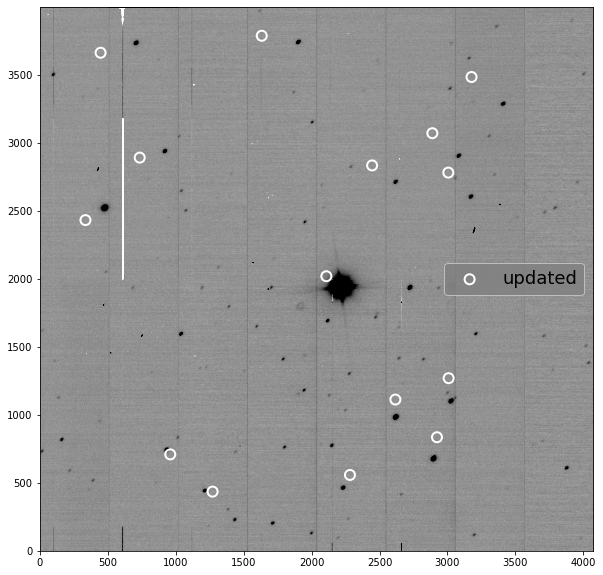

In [178]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
cat = updatedCatalogMagCut
color = 'white'
lw=2
label='updated'

ax.scatter(cat['centroid_x'], 
       cat['centroid_y'], 
       s=100, 
       facecolors='none', 
        edgecolors=color, lw=lw, 
       label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

So this didn't work... Was the input source catalog too far off from the actual source position ? When I did it "by hand" I needed rotation of ~6 deg, but for the astrometry matching the rotation needs to be less than 6 degrees...

### 1b) [works] Correct WCS using source detection catalog as input for  astrometry fit  <a id='detection'></a>
[Go to table of contents](#toc)

In [13]:
def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

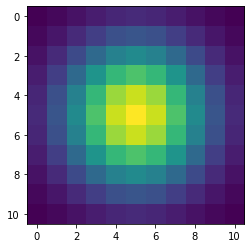

In [14]:
psf_array = gkern(l=11, sig=2.5)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)
plt.imshow(psf_image.array)

postIsr.setPsf(psf)

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay


#Use DM tasks to run: detection, measure using the simple PSF (no deblending)

schema = lsst.afw.table.SourceTable.makeMinimalSchema()

configDetection = SourceDetectionTask.ConfigClass()
configDetection.thresholdValue = 30 #30  # detection threshold in units of thresholdType
configDetection.thresholdType = "stdev"#"stdev"   # units for thresholdValue
configDetection.includeThresholdMultiplier = 1.0 
#configDetection.minPixels = 200 # 1000#
configDetection.minPixels = 500
#configDetection.charImage.background.weighting = False  
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=configDetection)


measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table

#create copy of image to explicitly set the PSF
from copy import deepcopy
exposure = deepcopy(postIsr)
exposure.setPsf(psf)

# Run the detect the measure tasks
detect_result = detect.run(table, exposure,)# weighing=False)

catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
measure.run(catalog, exposure)

/software/lsstsw/stack_20220125/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/meas_algorithms/gbe01a4569f+ccfec7bf50/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20220125/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/meas_algorithms/gbe01a4569f+ccfec7bf50/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


plot the source catalog 

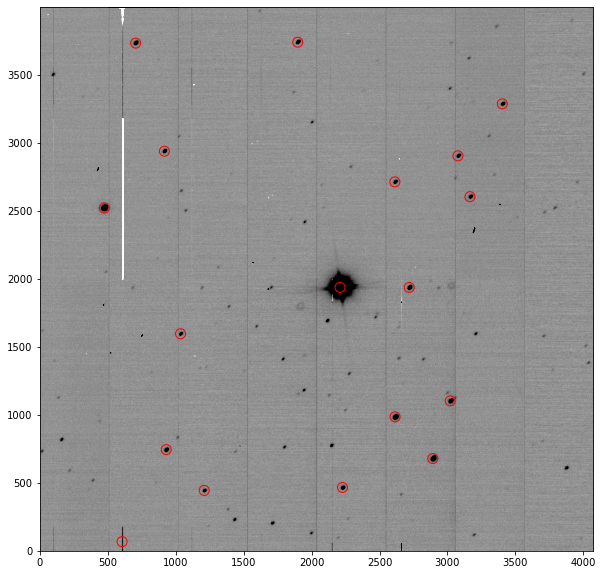

In [16]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()
data = postIsr.getImage().getArray()
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
ax.scatter(catalog['slot_Centroid_x'], catalog['slot_Centroid_y'],s=100,facecolors='none', edgecolors='red',)

Use that source catalog as an input for astrometry fit:

In [19]:
# Here I'm forcing the exposure
# to have the same name as the one in the Gaia catalog for now

from lsst.afw.image import FilterLabel
postIsr.setFilterLabel(FilterLabel('phot_g_mean'))

In [20]:
astromConfig = AstrometryTask.ConfigClass()
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.999
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 2
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15

schema = lsst.afw.table.SourceTable.makeMinimalSchema()
solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
results = solver.run(sourceCat=catalog, exposure=postIsr,)

Running the astrometry task updates the WCS attached to the postIsr exposure. Compare the original and updated WCS:

In [22]:
originalWcs

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [21]:
postIsr.getWcs()

FITS standard SkyWcs:
Sky Origin: (306.9575674280, -87.4684455328)
Pixel Origin: (1930.01, 1989.89)
Pixel Scale: 0.0957529 arcsec/pixel

ok, now it is differente! Pull sources based on that WCS from the reference catalog:

In [23]:
updatedDonutCat =  donutCatTask.run(dataRefs, postIsr, )

updatedCatalog  = updatedDonutCat.donutCatalog

mag_list = (updatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

updatedCatalog['mags'] = mag_array
mask = mag_array<16
updatedCatalogMagCut = updatedCatalog[mask]


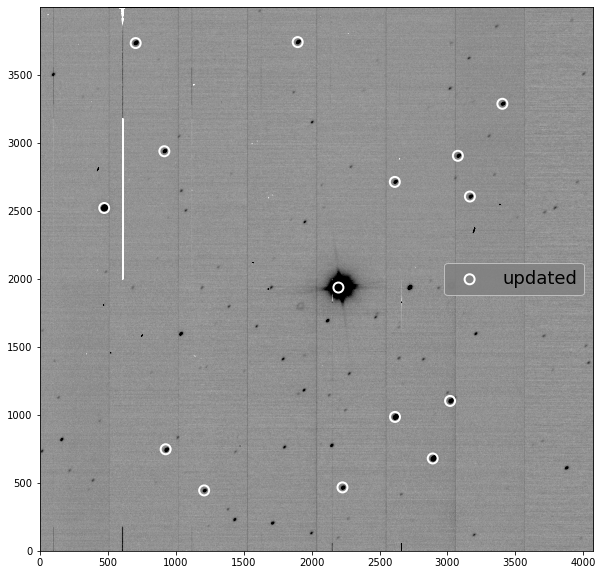

In [24]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
cat = updatedCatalogMagCut
color = 'white'
lw=2
label='updated'

ax.scatter(cat['centroid_x'], 
       cat['centroid_y'], 
       s=100, 
       facecolors='none', 
        edgecolors=color, lw=lw, 
       label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

ok, great! So these sources can be used as an input to run the AOS pipeline

## 2 Run Zernike estimation  <a id='zernikes'></a>
[Go to table of contents](#toc)

Next step is to update the WCS in the intra and extra focal exposures using this new in-focus WCS, and run the Zernike estimation:

In [25]:
exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800487},
                      collections=['u/scichris/Latiss/postISRex'])


exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800488},
                      collections=['u/scichris/Latiss/postISRex'])


In [26]:
focalWcs = postIsr.getWcs()

exposure_intra.setWcs(focalWcs)
exposure_extra.setWcs(focalWcs)

In [27]:
exp_pair = [exposure_intra, exposure_extra]

In [28]:
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200,donutTemplateSize=200)
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
estimateZernikeTask.instName = 'auxTel'
estimateZernikeTask.opticalModel = 'onAxis'

# This will take around a minute on medium instance on RSP
zernikeOutput = estimateZernikeTask.run(exp_pair, updatedCatalogMagCut, "LATISS")

/project/scichris/aos/ts_wep/python/lsst/ts/wep/task/EstimateZernikesBase.py:442: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def estimateZernikes(self, donutStampsExtra, donutStampsIntra):


In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
0 / 15
imageCoCenter: (x, y) = (   99.32,  101.49)

imageCoCenter: (x, y) = (   99.84,   99.38)

itr = 0, z4-z22
[ -1.  64. -85.  22.  35. -20.  -7. -17.  16.  -0.  -6.  -7.  -7.  -5.
  -1.   1.   3.   2.   6.]
itr = 1, z4-z22
[ -2.  65. -85.  23.  34. -21.  -8. -17.  16.  -0.  -6.  -7.  -6.  -5.
  -0.   1.   3.   2.   6.]
itr = 2, z4-z22
[ -2.  66. -87.  20.  33. -20.  -9. -17.  16.  -1.  -5.  -7.  -6.  -3.
  -0.   1.   3.   2.   6.]
itr = 3, z4-z22
[  -3.   91. -117.   21.   32.  -20.   -9.  -17.   15.   -0.   -5.   -7.
   -5.   -4.   -0.    1.    3.    2.    6.]
itr = 4, z4-z22
[  -3.  108. -138.   22.   33.  -21.   -8.  -17.   14.    0.   -6.   -6.
   -6.   -5.   -0.    1.    2.    2.    6.]
itr = 5, z4-z22
[ -18.  127. -123.    8.   11.  -27.  -12.  -22.   14.   -0.   -5.   -6.
    2.    0.   -0.    0.    3.    2.    7.]
itr 

itr = 6, z4-z22
[  7.  29. -55.  -0.  17. -30.  -6.  -8.   4.   0.   0.  -2.  -2.  -0.
  -0.   3.   2.  -1.   2.]
itr = 7, z4-z22
[  0.  35. -55.  -3.   7. -36.  -7.  -9.   4.   0.   0.  -2.   1.   1.
  -0.   2.   2.  -1.   2.]
itr = 8, z4-z22
[ -7.  40. -54.  -1.  13. -43.  -8. -10.   4.  -0.   0.  -1.  -1.   0.
  -0.   2.   2.  -1.   2.]
itr = 9, z4-z22
[ -5.  43. -54.  -3.  13. -41. -10. -11.   4.   0.   0.  -2.  -1.   1.
  -0.   2.   3.  -2.   2.]
itr = 10, z4-z22
[ -3.  47. -54.  -3.  13. -40. -11. -11.   4.   0.   0.  -3.  -1.   1.
  -0.   2.   4.  -3.   3.]
itr = 11, z4-z22
[ -0.  51. -54.  -1.  15. -39. -12. -12.   4.  -0.   1.  -3.  -2.   0.
  -0.   2.   4.  -3.   3.]
itr = 12, z4-z22
[  2.  54. -54.  -4.  13. -38. -14. -12.   4.   0.   1.  -4.  -1.   1.
  -0.   2.   5.  -4.   3.]
itr = 13, z4-z22
[  3.  57. -53.  -2.  13. -38. -15. -13.   4.   0.   1.  -5.  -1.   0.
  -0.   2.   6.  -5.   3.]
itr = 14, z4-z22
[  5.  60. -53.  -4.  12. -37. -16. -13.   4.   0.   1.  -5.  -1.  

itr = 0, z4-z22
[  7.  18. -17.   3.   4.  -3.   4.  -3.   2.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   0.]
itr = 1, z4-z22
[ 11.  16. -17.   2.   3.  -3.   4.  -3.   2.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   0.]
itr = 2, z4-z22
[ 15.  17. -18.   3.   4.  -3.   4.  -3.   3.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   1.]
itr = 3, z4-z22
[ 19.  26. -28.   2.   3.  -2.   4.  -3.   2.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   1.]
itr = 4, z4-z22
[ 23.  36. -38.   3.   4.  -2.   4.  -3.   2.  -1.  -1.  -1.  -1.  -1.
  -1.   0.  -0.  -0.   1.]
itr = 5, z4-z22
[ 23.  43. -38.  -0.  -1.  -4.   6.  -4.   2.  -1.  -1.  -1.   1.   0.
  -1.   0.  -0.  -0.   1.]
itr = 6, z4-z22
[ 20.  50. -38.   2.   2.  -5.   8.  -5.   2.  -1.  -1.  -1.  -0.  -0.
  -1.   0.  -0.  -0.   1.]
itr = 7, z4-z22
[ 17.  56. -39.  -0.  -0.  -6.  10.  -6.   2.  -1.  -1.  -1.   1.   0.
  -1.  -0.  -0.  -0.   1.]
itr = 8, z4-z22
[ 12.  62. -39.   3.   3.  -7.  12.  -7.   2.  -0.  -1.  -1.  -0.  -1.
 

itr = 9, z4-z22
[  8.  51. -21.   1.   1.   3.  -2.  -7.   1.  -0.  -3.  -3.   1.  -0.
   0.  -1.   1.  -1.   1.]
itr = 10, z4-z22
[  9.  55. -21.   1.  -1.   1.  -3.  -7.   1.  -0.  -4.  -4.   1.  -0.
   0.  -1.   1.  -1.   1.]
itr = 11, z4-z22
[ 10.  59. -22.   1.  -1.  -1.  -3.  -8.   1.  -0.  -4.  -5.   1.  -0.
   0.  -1.   1.  -1.   2.]
itr = 12, z4-z22
[ 11.  64. -22.   1.  -1.  -3.  -3.  -8.   1.  -0.  -5.  -7.   2.  -0.
   0.  -1.   2.  -1.   2.]
itr = 13, z4-z22
[ 13.  68. -22.   2.  -2.  -4.  -3.  -8.   1.  -0.  -6.  -8.   2.  -0.
  -0.  -1.   2.  -1.   2.]
itr = 14, z4-z22
[ 13.  72. -22.   3.  -0.  -6.  -3.  -8.   1.  -0.  -7.  -9.   1.  -1.
  -0.  -1.   2.  -2.   2.]
14 / 15
imageCoCenter: (x, y) = (   98.66,   99.74)

imageCoCenter: (x, y) = (  100.00,   99.46)

itr = 0, z4-z22
[-2. 12. -2. -7.  5. -4. -1. -1.  0. -1. -1. -1. -1.  1.  0. -0. -1. -1.
  1.]
itr = 1, z4-z22
[-4. 12. -1. -7.  5. -3. -1. -1.  0. -1. -1. -1. -1.  2. -0. -0. -1. -1.
  1.]
itr = 2, z4-z22
[-5. 12

In [37]:
year=2021
monthDay = '0908'
exp = 487
print(f'zerDic_{year}{monthDay}00{exp}_ex.npy')


zerDic_2021090800487.npy


In [38]:
# store zernikes as a dict and illustrate the result 

zernikes = zernikeOutput.getDict()
fname = f'zerDic_{year}{monthDay}00{exp}_ex.npy'
np.save(fname,zernikes)
print(f'Stored the results as {fname} ')

Stored the results as zerDic_2021090800487_ex.npy 


In [45]:
expIntra=487
zkResultsFile = f'zerDic_{year}{monthDay}00{expIntra}_ex.npy'
zkFit = np.load(zkResultsFile, allow_pickle=True).item()

In [46]:
zkFit

{'outputZernikesAvg': array([-0.00736736,  0.09894695, -0.02199616,  0.00372416,  0.00648778,
        -0.02470382, -0.00666813, -0.01405157,  0.00250448, -0.00129337,
        -0.00670609, -0.00420586, -0.00032336, -0.00054846, -0.00043126,
         0.00035698,  0.00017884, -0.00038609,  0.00353187]),
 'outputZernikesRaw': array([[-1.63903031e-02,  1.73667441e-01, -7.46960084e-02,
          1.30535266e-02,  1.57408890e-02, -4.88776144e-02,
         -2.68409376e-02, -3.53487591e-02,  1.45216658e-02,
         -1.43262672e-04, -1.26882997e-02, -1.49357907e-02,
          2.84385481e-04, -9.60625512e-04, -1.00206155e-03,
         -8.84122573e-04,  6.09150984e-03,  3.97009453e-03,
          9.26226988e-03],
        [-5.29790305e-02,  1.65844387e-01, -3.58797007e-03,
         -2.70302663e-03,  4.54775072e-03, -4.28603267e-02,
         -3.12852169e-02, -2.99016657e-02,  8.24681643e-03,
          1.34926299e-03, -1.51932342e-02, -1.13710533e-02,
          4.08886705e-04,  6.79949579e-04,  4.6882

In [59]:
# plot the truth vs simulation... 
from lsst.daf import butler as dafButler
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from copy import copy
import yaml
from astropy.io import fits  
from astropy.visualization import ZScaleInterval

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


def plot_zernike_image(expIntra=487,expExtra=488, year='2021',monthDay='0908',
                       zkResultsFile=None,
                       collection='u/scichris/Latiss/postISRex'):

    # plot the figure ...   
    fig = plt.figure(figsize=(14, 5))

    ####################################
    ### left - plot the fit results  ###
    #################################### 

    #add_axes([xmin,ymin,dx,dy]) 
    ax1 = fig.add_axes([0,0,0.6,1])  

    #for exp in expIntra:
    if zkResultsFile == None:
        # use the provided year, month, day, exposure number, to 
        # construct file name 
        zkResultsFile = f'zerDic_{year}{monthDay}00{expIntra}_ex.npy'
    print(f'Using results from {zkResultsFile}')
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()

    for i in range(len(zkFit['outputZernikesRaw'])):
        
        ax1.plot(np.arange(4, 23),1000*zkFit['outputZernikesRaw'][i], 
                 '-d', label=f'donut {i}')

    ax1.set_xlabel('Zernike Number',)
    ax1.set_ylabel('Zernike Coefficient [nanometers]', )
    ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.55, 0.65],
              ncol=2)
    ax1.set_xticks(np.arange(4,23)[::2])
    ax1.grid()

    ax1.set_title(f'auxTel test data {year}{monthDay}', fontsize=18)


    ###############################################
    ### right - plot the postISR image ###
    ###############################################


    ax2 = fig.add_axes([0.6,0,0.4,1])
    butler = dafButler.Butler('/repo/main/')
    datasetRefOrType='postISRCCD'; 
    exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                                 'exposure':int(f'{year}{monthDay}00{expIntra}')
                                                    }, collections=[collection])
    zscale = ZScaleInterval()
    data = exposure_intra.image.array
    vmin, vmax = zscale.get_limits(data)

    ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)

    nrows = len(zkFit['donutStampsExtra'])
    for i in range(nrows):
        donut = zkFit['donutStampsExtra'][i]
        xy = donut.centroid_position

        # plot the cross marking that the donut was used 
        ax2.scatter(xy[0],xy[1],s=200,marker='+',c='m', lw=4)

        # plot the donut number on the plot 
        xtext,ytext = xy[0],xy[1]
        ytext -= 60
        if xtext+100 > 4096:
            xtext -= 250
        if len(str(i))>1: # move to the left label thats too long 
            #print(i, 'moving')
            xtext -=340 
        else:
            xtext -=260
        ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
    ax2.yaxis.tick_right()
    ax2.set_xlabel('x [px]')
    ax2.set_ylabel('y [px]')
    ax2.yaxis.set_label_position("right")
    ax2.set_title(f'exp{expIntra}')

Using results from zerDic_2021090800487_ex.npy


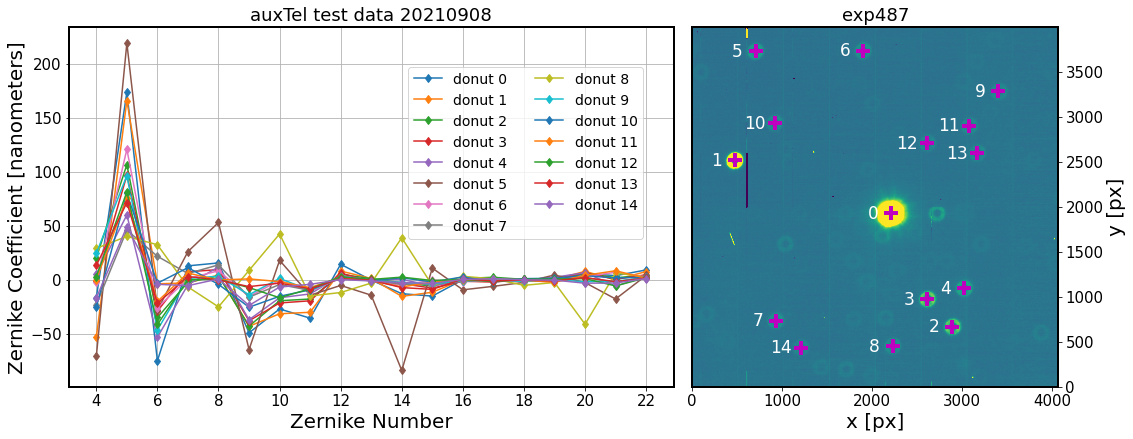

In [61]:
plot_zernike_image()

# Another way: use donut template fitting on defocal images to get the source catalog (doesn't use WCS information) <a id='template'></a>
[Go to table of contents](#toc)

## Load the raw defocal images, do the ISR <a id='loadDefocal'></a>
[Go to table of contents](#toc)


Same as above -  [preview the raws](#raws) and [run the ISR](#isr)
 



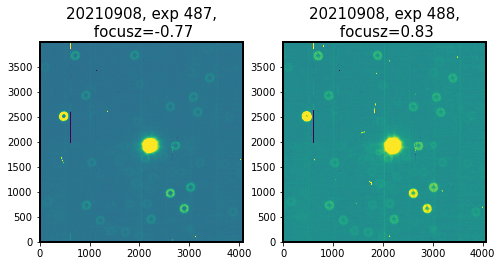

In [72]:
preview_auxtel_exposures(monthDay='0908', expStart=487, expEnd=489,
                         datasetRefOrType='postISRCCD', 
                         collection='u/scichris/Latiss/postISRex')

## Run Zernike estimation using sources from donut template fitting <a id='fitDonuts'></a>
[Go to table of contents](#toc)

In [53]:
def fit_zernikes(estimateZernikeTask, expIntra=318, expExtra=339, year='2021', monthDay='1104',
                datasetRefOrType='postISRCCD', collection='u/scichris/Latiss/postISRex',):

    butler = dafButler.Butler('/repo/main/')
    
    # load the exposure pair 
    exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{expIntra}')
                                                }, collections=[collection])

    exposure_extra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{expExtra}')
                                                }, collections=[collection])

    # declare the exposure pair
    exposure_pair = [exposure_intra, exposure_extra ]

    print(f'\nRunning Zk fitting for exposures {expIntra, expExtra}')


    # get the  template from estimateZernikeTask. 

    detectorName = exposure_extra.getDetector().getName()
    pixelScale = exposure_extra.getWcs().getPixelScale().asArcseconds()
    defocalType = DefocalType.Extra
    template = estimateZernikeTask.getTemplate(detectorName, defocalType, pixelScale)

    # detect donuts  in one of the defocal images 
    detector = DonutDetector()
    expArray = copy(exposure_extra.getImage().getArray())

    # use the adaptive threshold finding algorithm for the binary image 
    donutDf = detector.detectDonuts(expArray, template, blendRadius=200,
                                       peakThreshold=0.99, binaryChoice = 'deblend')
    
    np.save(f'donuts_{year}{monthDay}00{expIntra}_{expExtra}_template.npy', donutDf)

    # make a donut catalog :
    ## remove the blends in donut catalog 
    donutDfClean = donutDf[~donutDf['blended']].copy()

    ## update column names and content 
    donutCatUpd = update_donut_cat(donutDfClean.copy(), exposure_intra)

    # run zernike estimation
    zernikeOutput = estimateZernikeTask.run(exposure_pair, donutCatUpd, "LATISS")

    # store zernikes as dict
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{year}{monthDay}00{expIntra}_{expExtra}.npy'
    np.save(fname,zernikes)
    print(f'Stored the results as {fname} ')
    
def update_donut_cat(donutCat, exposure):
    
    ## rename columns, as the EstimateZernikes  expects different names:
    ## coord_ra; coord_dec; centroid_x; centroid_y; source_flux; detector; mags
    
    
    # and add a detector column 
    donutCat['detector'] = exposure.getDetector().getName()

    # rename columns: transpose y --> x 
    donutCat = donutCat.rename(columns={"y_center":"centroid_x", "x_center":"centroid_y"})
    
    # pass whatever ra,dec to the catalog - they're not used, but are required to be there 
    wcs = exposure.getWcs()
    x = np.array(donutCat['centroid_x'].values)
    y = np.array(donutCat['centroid_y'].values)

    x = np.zeros(0)
    for row in donutCat['centroid_x'] : 
        x = np.append(x, row)

    ra,dec = wcs.pixelToSkyArray(x,y,degrees=False)  
    
    donutCat['coord_ra'] = ra
    donutCat['coord_dec'] = dec
    return donutCat

Initialize estimate Zernike task, and run Zk fitting:

In [54]:
# initialize the zernike Task - has to be done only once 
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200,donutTemplateSize=200)
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
estimateZernikeTask.instName = 'auxTel'
estimateZernikeTask.opticalModel = 'onAxis'

fit_zernikes(estimateZernikeTask, expIntra=487, expExtra=488, year='2021', monthDay='0908',
                datasetRefOrType='postISRCCD', collection='u/scichris/Latiss/postISRex',)


Running Zk fitting for exposures (487, 488)
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
Using deblendAdapt _getImgBinaryAdapt to get image binary
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
0 / 2
imageCoCenter: (x, y) = (   99.28,  100.80)

imageCoCenter: (x, y) = (   99.40,   99.52)

itr = 0, z4-z22
[-10.  37. -39.  26.  12. -17. -12. -12.   9.   1.  -5.  -4.  -2.  -5.
   1.   2.   2.   1.   5.]
itr = 1, z4-z22
[-14.  38. -39.  24.  12. -16. -12. -12.   9.   1.  -5.  -4.  -2.  -4.
   1.   1.   3.   1.   5.]
itr = 2, z4-z22
[-18.  38. -39.  25.  13. -17. -12. -12.   9.   1.  -5.  -4.  -3.  -5.
   1.   2.   2.   1.   5.]
itr = 3, z4-z22
[-21.  55. -56.  26.  13. -18. -13. -12.   9.   1.  -5.  -4.  -3.  -6.
   1.   2.   2.   1.   5.]
itr = 4, z4-z22
[-24.  71. -70.  25.  13. -18. -12. -12.   8.   1.  -5.  -4.  -3.  -4.
   1.   1.   2.   1. 

Plot the results:

Using results from zerDic_2021090800487_488.npy


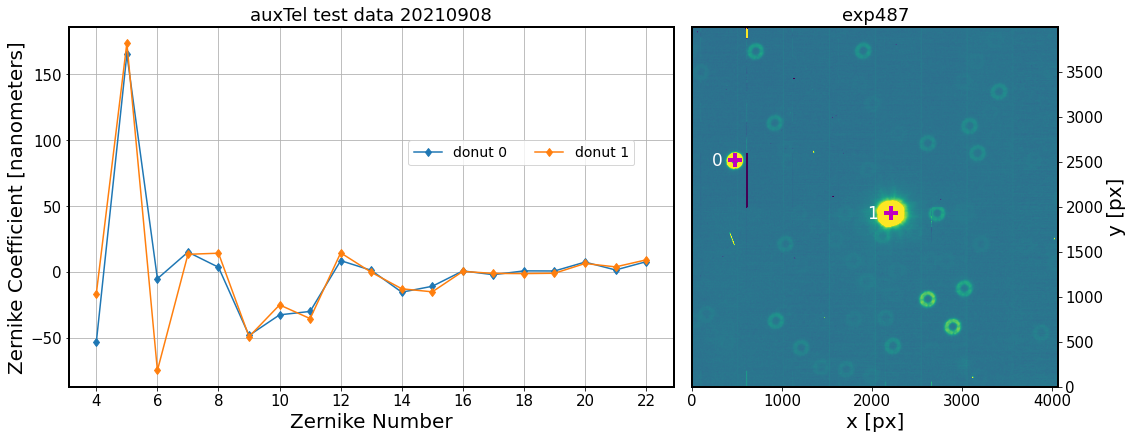

In [60]:
expIntra=487; expExtra=488; year='2021';monthDay='0908'
plot_zernike_image(zkResultsFile=f'zerDic_{year}{monthDay}00{expIntra}_{expExtra}.npy')

# Summary and conclusion <a id='summary'></a>
[Go to table of contents](#toc)

There are drawbacks to both methods we use to select sources.  

First, the [method detecting sources](#detection) in the in-focus image using `sourceDetectionTask` relies on provided PSF (since PSF characterization is lacking), and on set detection thresholds (in particular, `configDetection.thresholdValue` and `configDetection.minPixels` ). Setting these to be too low may result in eg. an error in that all pixels are masked and background cannot be estimated. 



Second, the [method of template fitting](#fitDonuts) to detect defocal donuts using  `DonutDetector` `detectDonuts` depends on the settings passed therein, consisting of `blendRadius` in pixels, and `peakThreshold`. We also made a choice to remove the `blended` donuts to clean up the catalog. This method works well when required  to detect a few brightest donuts in the image. However, if it is  important to use as many donuts as possible, then it may be easier to select them using a magnitude cut  on the reference star catalog used in the first method.